# Proyecto Final
## autor: Roberto Rios 20979
## autor: Javier Mombiela 20067
### Descripcion: Red Neuronal Recurrente que predice el ganador de un partido de la liga BBVA.

In [76]:
# importando as bibliotecas necessárias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.layers import Dense, Embedding, LSTM, Dropout, RNN

Carga de data

In [77]:
# cargamos la data
data = pd.read_csv('temporadas.csv')
print(data.count())
data

Div         3800
Date        3800
HomeTeam    3800
AwayTeam    3800
FTHG        3800
            ... 
PCAHA       1520
MaxCAHH     1520
MaxCAHA     1520
AvgCAHH     1520
AvgCAHA     1520
Length: 129, dtype: int64


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,SP1,17/08/13,Sociedad,Getafe,2,0,H,1,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SP1,17/08/13,Valencia,Malaga,1,0,H,0,0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SP1,17/08/13,Valladolid,Ath Bilbao,1,2,A,1,1,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SP1,18/08/13,Barcelona,Levante,7,0,H,6,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SP1,18/08/13,Osasuna,Granada,1,2,A,0,2,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,SP1,04/06/2023,Betis,Valencia,1,1,D,1,0,H,...,1.71,0.00,2.14,1.80,2.17,1.78,2.17,1.86,2.08,1.79
3796,SP1,04/06/2023,Celta,Barcelona,2,1,H,1,0,H,...,1.91,0.00,2.08,1.85,2.09,1.83,2.15,1.89,2.04,1.83
3797,SP1,04/06/2023,Elche,Cadiz,1,1,D,0,1,A,...,1.94,0.00,1.73,2.08,1.75,2.19,1.93,2.23,1.83,2.04
3798,SP1,04/06/2023,Espanol,Almeria,3,3,D,1,1,D,...,2.62,-0.25,2.05,1.75,2.12,1.81,2.16,1.83,2.08,1.78


Calculamos performance

In [78]:
# 1. Calculamos el ratio de partidos ganados
home_wins = data[data['FTR'] == 'H'].groupby('HomeTeam').size()
away_wins = data[data['FTR'] == 'A'].groupby('AwayTeam').size()
total_matches = data.groupby('HomeTeam').size() + data.groupby('AwayTeam').size()
win_rate = (home_wins + away_wins) / total_matches

# 2. Calculamos el promdio de goles anotados
home_goals = data.groupby('HomeTeam')['FTHG'].mean()
away_goals = data.groupby('AwayTeam')['FTAG'].mean()
avg_goals_scored = (home_goals + away_goals) / 2

# 3. Calculamos el promedio de goles recibidos
home_conceded = data.groupby('HomeTeam')['FTAG'].mean()
away_conceded = data.groupby('AwayTeam')['FTHG'].mean()
avg_goals_conceded = (home_conceded + away_conceded) / 2

In [79]:
data['WinRate'] = data['HomeTeam'].map(win_rate) + data['AwayTeam'].map(win_rate)
data['AvgGoalsScored'] = data['HomeTeam'].map(avg_goals_scored) + data['AwayTeam'].map(avg_goals_scored)
data['AvgGoalsConceded'] = data['HomeTeam'].map(avg_goals_conceded) + data['AwayTeam'].map(avg_goals_conceded)
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,WinRate,AvgGoalsScored,AvgGoalsConceded
0,SP1,17/08/13,Sociedad,Getafe,2,0,H,1,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.708480,2.360526,2.461988
1,SP1,17/08/13,Valencia,Malaga,1,0,H,0,0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.663158,2.392105,2.539474
2,SP1,17/08/13,Valladolid,Ath Bilbao,1,2,A,1,1,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.607895,2.147368,2.550000
3,SP1,18/08/13,Barcelona,Levante,7,0,H,6,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.969737,3.624342,2.451316
4,SP1,18/08/13,Osasuna,Granada,1,2,A,0,2,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.548246,2.057018,3.201128


Preprocesamiento de data

In [80]:
# 1. codifcamos las variable categoricas
label_encoder = LabelEncoder()
data['HomeTeam'] = label_encoder.fit_transform(data['HomeTeam'])
data['AwayTeam'] = label_encoder.fit_transform(data['AwayTeam'])

print("Codificacion de equipos:")
for class_, label in enumerate(label_encoder.classes_):
    print(f"{class_}: {label}")


Codificacion de equipos:
0: Alaves
1: Almeria
2: Ath Bilbao
3: Ath Madrid
4: Barcelona
5: Betis
6: Cadiz
7: Celta
8: Cordoba
9: Eibar
10: Elche
11: Espanol
12: Getafe
13: Girona
14: Granada
15: Huesca
16: La Coruna
17: Las Palmas
18: Leganes
19: Levante
20: Malaga
21: Mallorca
22: Osasuna
23: Real Madrid
24: Sevilla
25: Sociedad
26: Sp Gijon
27: Valencia
28: Valladolid
29: Vallecano
30: Villarreal


In [81]:
# 2. One hot encoding de Y
y = pd.get_dummies(data['FTR'])
print(y.head())

# renombrar las columnas
y.columns =  ['FTR_A', 'FTR_D', 'FTR_H']
# Concatenate the one-hot encoded DataFrame with the original DataFrame
data = pd.concat([data, y], axis=1)
data.head()

       A      D      H
0  False  False   True
1  False  False   True
2   True  False  False
3  False  False   True
4   True  False  False


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,WinRate,AvgGoalsScored,AvgGoalsConceded,FTR_A,FTR_D,FTR_H
0,SP1,17/08/13,25,12,2,0,H,1,0,H,...,NaN,NaN,NaN,NaN,0.708480,2.360526,2.461988,False,False,True
1,SP1,17/08/13,27,20,1,0,H,0,0,D,...,NaN,NaN,NaN,NaN,0.663158,2.392105,2.539474,False,False,True
2,SP1,17/08/13,28,2,1,2,A,1,1,D,...,NaN,NaN,NaN,NaN,0.607895,2.147368,2.550000,True,False,False
3,SP1,18/08/13,4,19,7,0,H,6,0,H,...,NaN,NaN,NaN,NaN,0.969737,3.624342,2.451316,False,False,True
4,SP1,18/08/13,22,14,1,2,A,0,2,A,...,NaN,NaN,NaN,NaN,0.548246,2.057018,3.201128,True,False,False


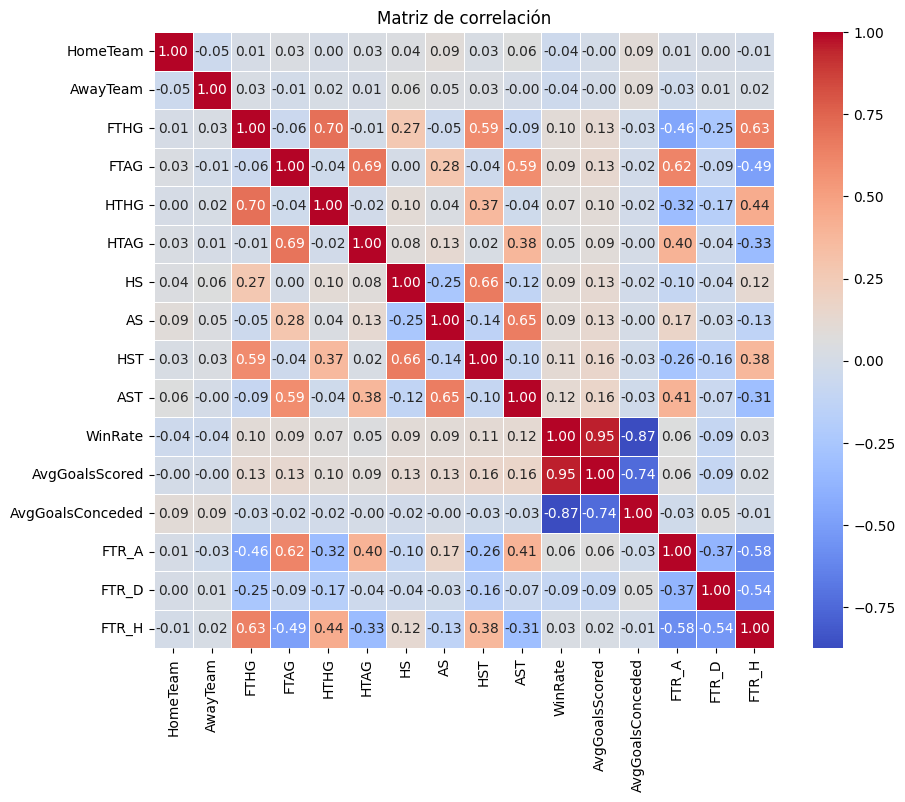

In [82]:
# 3. matriz de correlacion
numeric_columns = ["HomeTeam", "AwayTeam", "FTHG", "FTAG", "HTHG", "HTAG", "HS", "AS", "HST", "AST", "WinRate", "AvgGoalsScored", "AvgGoalsConceded"]

# Filtrar el DataFrame con las columnas numéricas
data_numeric = data[numeric_columns + ["FTR_A", "FTR_D", "FTR_H"]]

# Calcular la matriz de correlación
correlation_matrix = data_numeric.corr()

# Visualizar la matriz de correlación en un heatmap
plt.figure(figsize=(10, 8))
plt.title("Matriz de correlación")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

In [83]:
# 4. Definimos las variables X
X = data[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'WinRate', 'AvgGoalsScored', 'AvgGoalsConceded']]

In [ ]:
# normalizamos los datos
scaler = MinMaxScaler()
X[['WinRate', 'AvgGoalsScored', 'AvgGoalsConceded']] = scaler.fit_transform(X[['WinRate', 'AvgGoalsScored', 'AvgGoalsConceded']])

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)